# Recession Prediction Machine Learning Modeling with Economic Indicators

## 2. Audience and Problem Statement

This section outlines the target audience and defines the core problem addressed by the recession prediction model:

### Audience
The people requesting recession prediction insights embedded in our dashboard are **economic policymakers** and **financial institution analysts**.

#### Why might policymakers care about this?
- Policymakers aim to maintain **economic stability and growth**.
- To **prevent or mitigate recessions**, they need to implement timely fiscal or monetary interventions (e.g., rate cuts, stimulus packages).
- To ensure **effective interventions**, they want to identify economic indicators that signal a recession early, allowing proactive measures to support businesses and households.
- If a recession is predicted with high confidence, policymakers can **adjust interest rates**, **increase government spending**, or **provide tax relief** to stabilize the economy.

#### Why might financial analysts care about this?
- Analysts aim to **protect investments** and **optimize portfolio performance**.
- To **safeguard client assets**, they need to anticipate recessions to adjust investment strategies (e.g., shifting to defensive stocks or bonds).
- To **optimize strategies**, analysts want to identify recession signals as early as possible to reallocate resources and advise clients effectively.
- This might involve **reducing exposure to equities**, **increasing cash reserves**, or **hedging against market downturns**.

### Problem Statement
**How early can we confidently predict an impending recession** using economic indicators such as yield spreads, unemployment, consumer confidence, and industrial production, enabling policymakers and financial analysts to take preemptive actions to mitigate economic downturns?

### Explanation
- This aligns with the recession prediction modeling goal, focusing on **early detection** using the indicators already explored (e.g., S&P 500, consumer confidence, etc.).
- It emphasizes early identification for intervention, tailored to an **economic context**.

## Setup and Imports
This section initializes the foundation of our analysis by importing essential libraries for data manipulation, 
machine learning, and visualization, ensuring all necessary tools are available for recession prediction.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define date range
start_date = datetime(1990, 1, 1)
end_date = datetime(2025, 4, 1)  # Current date

## Fetch Recession Labels
Here, we define a function to generate binary recession labels based on historical NBER data, providing the target variable for our predictive modeling efforts.

In [4]:
def fetch_recession_labels(start_date, end_date):
    """
    Creates binary recession labels based on NBER recession dates
    """
    # NBER recession periods (manually defined based on historical data up to 2023)
    recession_periods = [
        ('1990-07-01', '1991-03-31'),
        ('2001-03-01', '2001-11-30'),
        ('2007-12-01', '2009-06-30'),
        ('2020-02-01', '2020-04-30')
    ]
    
    print(f"Creating recession labels based on {len(recession_periods)} historical recession periods")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    labels = pd.Series(0, index=dates)
    
    for start, end in recession_periods:
        labels.loc[start:end] = 1
    
    return labels

## Data Exploration and Visualization
This section dives into the initial exploration of economic indicators, offering visual insights into trends and relationships while highlighting recession periods for context.

In [5]:
# Fetch data and set 'DATE' as index
economic_indicators = pd.read_csv('./data/economic_indicators.csv', 
                                  index_col='DATE', 
                                  parse_dates=True)

# Display basic information
print("\nDataset shape:", economic_indicators.shape)
print("\nFirst 5 rows:")
print(economic_indicators.head())


Dataset shape: (9318, 14)

First 5 rows:
            unemployment  yield_spread  industrial_prod  consumer_conf   LEI  \
DATE                                                                           
1990-01-01           5.4           NaN          61.6352           93.0  1.71   
1990-01-02           5.4          0.07          61.6352           93.0  1.71   
1990-01-03           5.4          0.05          61.6352           93.0  1.71   
1990-01-04           5.4          0.06          61.6352           93.0  1.71   
1990-01-05           5.4          0.09          61.6352           93.0  1.71   

              CPI    GDP_Growth  recession_probabilities  fed_funds_rate  \
DATE                                                                       
1990-01-01  127.5  10047.386000                      0.2            8.23   
1990-01-02  127.5  10047.947062                      0.2            8.23   
1990-01-03  127.5  10048.508123                      0.2            8.23   
1990-01-04  127.5

In [6]:
# Fetch recession labels
recession_labels = fetch_recession_labels(start_date, 
                                          end_date)
recession_labels = recession_labels.reindex(economic_indicators.index, 
                                            method='ffill')

Creating recession labels based on 4 historical recession periods


In [7]:
# Create a DataFrame with both data and labels for visualization
economic_indicators_with_labels = economic_indicators.copy()
economic_indicators_with_labels['Recession'] = recession_labels

In [8]:
# Calculate required rows based on number of indicators
num_indicators = len(economic_indicators.columns)
rows = int(np.ceil(num_indicators / 2))  # 2 columns, adjust rows dynamically

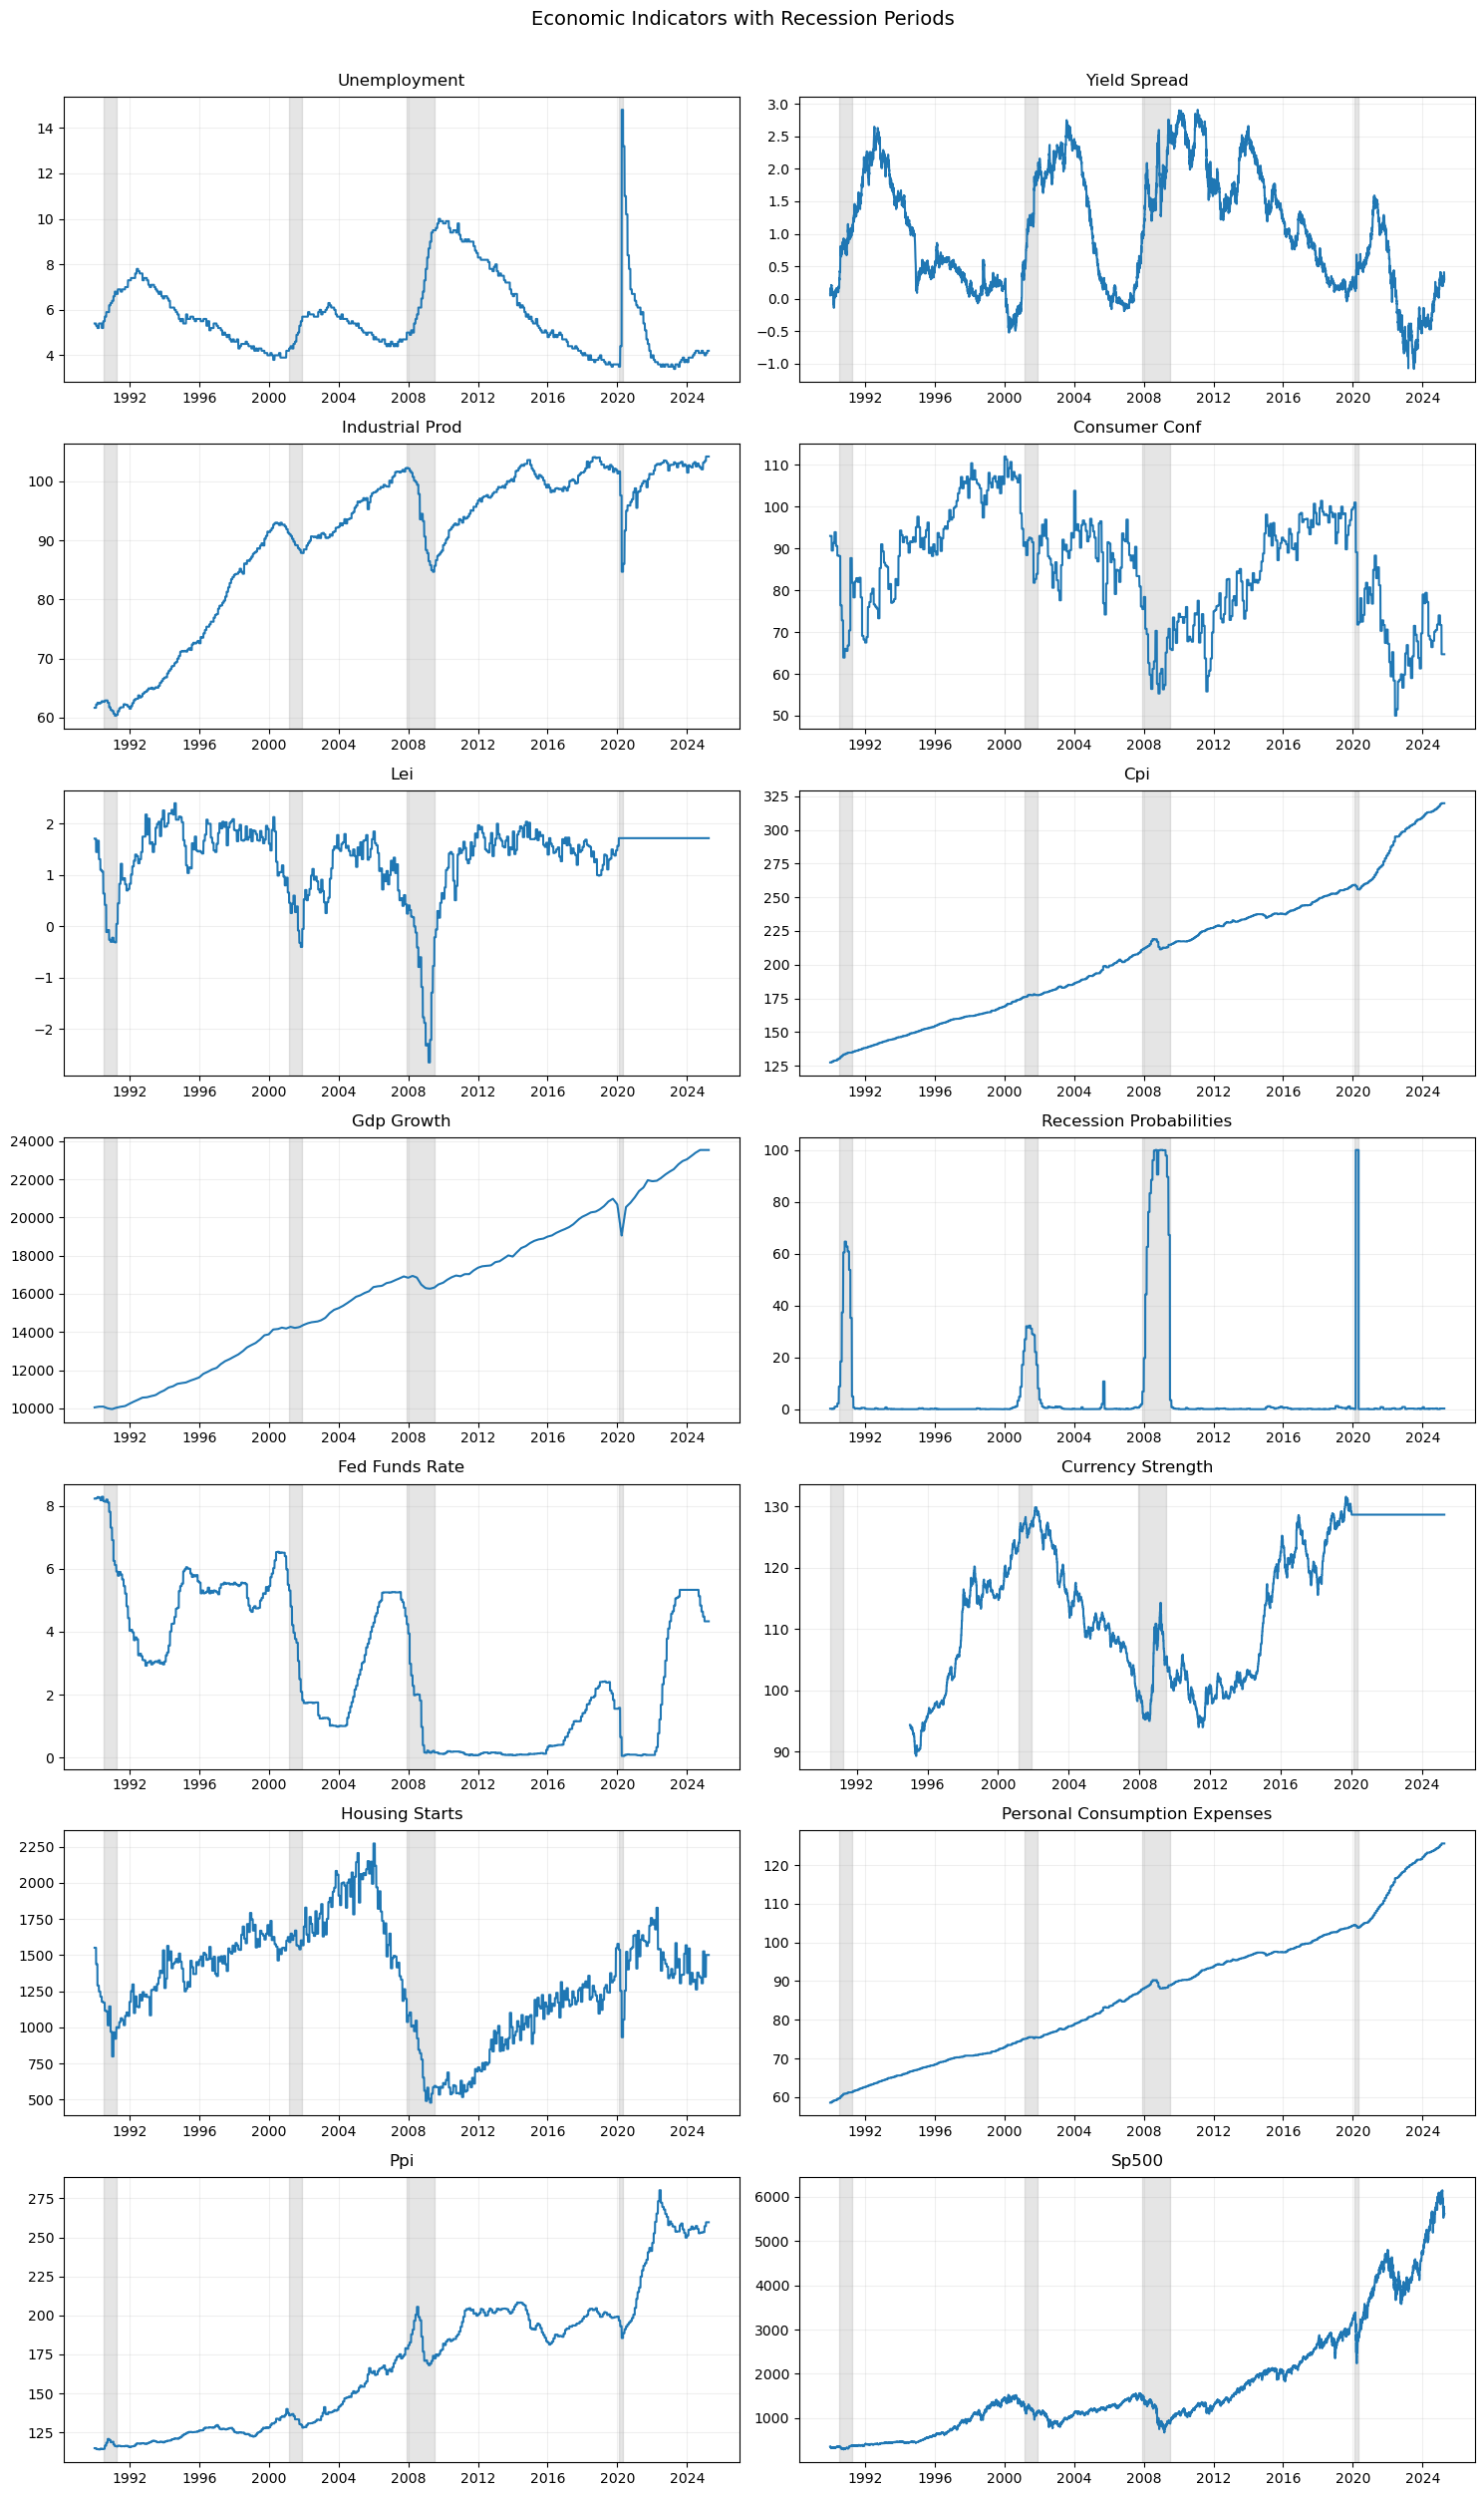

In [19]:
# Plot economic indicators
plt.figure(figsize=(15, 3.5 * rows))

for i, column in enumerate(economic_indicators.columns):
    plt.subplot(rows, 2, i+1)  # 2 columns, dynamic rows
    plt.plot(economic_indicators.index, economic_indicators[column], lw=1.5)
    
    # Highlight recession periods
    for start, end in [('1990-07-01', '1991-03-31'), 
                       ('2001-03-01', '2001-11-30'),
                       ('2007-12-01', '2009-06-30'),
                       ('2020-02-01', '2020-04-30')]:
        plt.axvspan(start, end, color='gray', alpha=0.2)
    
    plt.title(column.replace('_', ' ').title(), pad=8)
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.suptitle("Economic Indicators with Recession Periods", y=1.02, fontsize=14)

# Save the plot to the images folder
plt.savefig('images/economic_indicators_with_recession_periods.png', dpi=300, bbox_inches='tight')
plt.show() 

## **High-Level Observations**

### 1. **Yield Curve Inversion Precedes Recessions**
- **Yield Spread (10Y - 2Y)** drops **below zero** (inverts) **before each recession**:
  - Around 2000 → Dotcom bubble burst (2001 recession)  
  - Around 2006–2007 → Housing bubble (2008 recession)  
  - Around 2019 → COVID-triggered recession (2020)
- This supports the well-known theory that **inverted yield curves are strong recession predictors**.
- *The yield spread reflects investor expectations about future growth and interest rates — when short-term rates exceed long-term ones, it's often a warning sign.*

---

### 2. **Unemployment Lags Recessions**
- **Unemployment spikes during and after** recessions.
  - It doesn't help as much for early warnings, but it's an **effective indicator of economic damage**.
  - COVID-19 shows the highest spike, highlighting **sudden economic shocks**.
- *This rate shows how many people are actively seeking work — a key sign of labor market stress once downturns begin.*

---

### 3. **Consumer Sentiment Declines Ahead of and During Recessions**
- Consumer confidence **falls sharply before or at the start** of every recession.
- Lower sentiment = reduced spending → economic slowdown.
- *This index captures how optimistic people feel about the economy — when consumers get nervous, spending slows down.*

---

### 4. **Industrial Production Slows or Dips During Recessions**
- Clear drop during:
  - 2001  
  - 2008  
  - 2020
- It's **sensitive to demand, exports, and investment**, making it a **good concurrent indicator**.
- *Tracks how many goods factories and utilities are producing — it tends to drop quickly when the economy weakens.*

---

### 5. **Housing Starts Are a Leading Indicator**
- Drop sharply **before or early in** recession periods (especially in 2006–2007).
- Housing is **rate-sensitive**, so it responds early when monetary policy tightens.
- *New home construction reacts quickly to interest rate changes — when housing slows down, it often signals deeper problems ahead.*

---

### 6. **S&P 500 Reacts Before Official Recession Start**
- The stock market **dips early**, reflecting forward-looking investor sentiment.
- Useful when **combined with volatility indicators** like the VIX.
- *Stock prices move on expectations, so downturns in the S&P 500 often show up before economic data catches up.*

---

### 7. **CPI, PCE, and Fed Funds Rate**
- **Inflation (CPI)** rises slowly and steadily, but sharp spikes can force Fed actions.
- **Fed Funds Rate** increases often **precede a recession** due to tightening:
  - Before 2001, 2008, and 2020.
- Suggests: **Aggressive rate hikes can trigger downturns**.
- *Inflation gauges like CPI and PCE track price growth. The Fed responds with rate hikes, which can cool off the economy — sometimes too much.*

---

### 8. **GDP Growth and Personal Consumption**
- Both decline during recessions.
- They're lagging or concurrent indicators — helpful for **confirmation**, not prediction.
- *GDP shows overall economic output, while personal consumption reflects household spending — both shrink when recessions hit.*

---

### 9. **Currency Strength and LEI (Leading Economic Index)**
- Currency strength varies more by global dynamics, but extreme shifts may contribute to trade issues.
- **LEI drops noticeably before 2008 and 2020** — helpful to watch closely in real-time models.
- *LEI is a composite of multiple forward-looking indicators. It’s designed to signal turning points. Currency strength shows trade competitiveness and investor flows.*
---
Absolutely! Here's how you can add a new section about **PPI** (Producer Price Index) in the same format and tone as the rest of your high-level observations:

---

### 10. **PPI Reflects Supply-Side Pressures During Recessions**
- **PPI tends to plateau or drop during recessions**, particularly:
  - 2001 → Mild decline as manufacturing cooled.  
  - 2008 → Sharp fall as oil prices collapsed and demand evaporated.  
  - 2020 → Temporary dip due to COVID disruptions, followed by strong rebound from supply chain shocks.
- PPI captures **producer-level inflation** — often reacts to raw material and energy costs.
- *When input costs fall or demand weakens, producers can't pass on higher prices — so PPI often dips before or during economic downturns.*

> *Adding PPI gives us insight into cost-side inflation trends, complementing CPI (consumer-side). It’s especially useful for detecting recession risk tied to global supply shocks, commodity volatility, or margin pressure in manufacturing.*
---

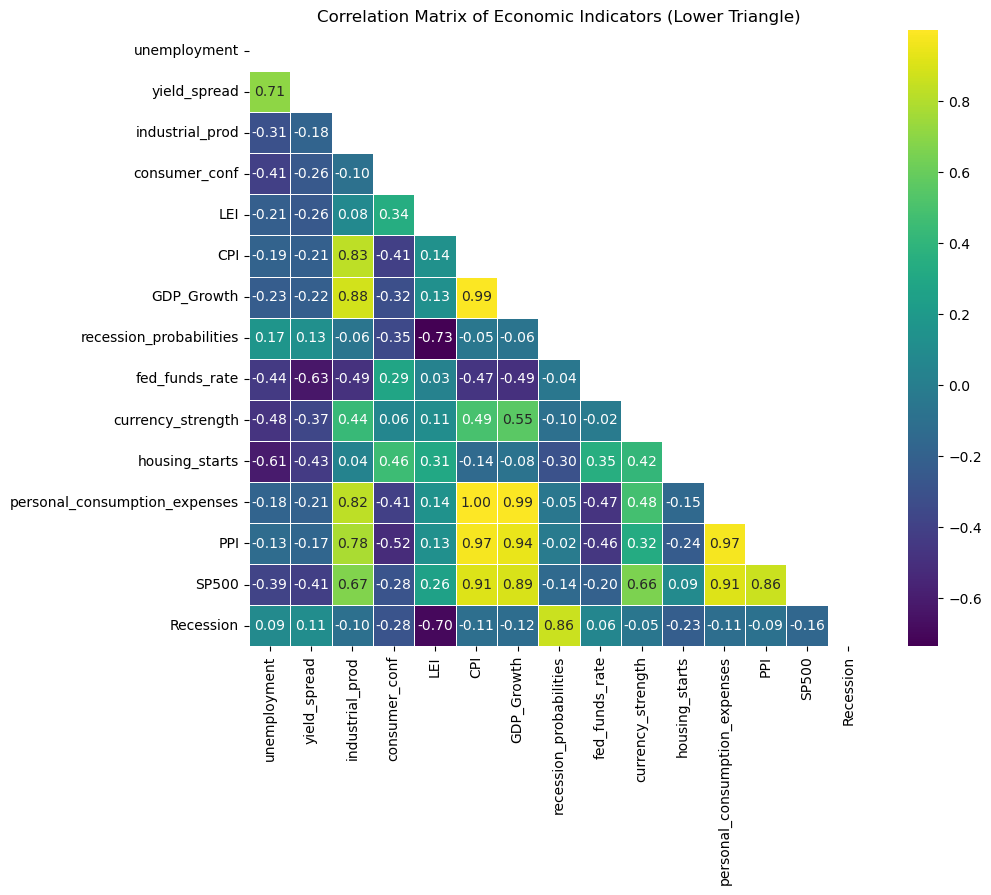

In [20]:
# Calculate correlation matrix and show only lower triangle with colorblind-friendly palette
plt.figure(figsize=(10, 8))
correlation = economic_indicators_with_labels.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))
# Use a colorblind-friendly colormap (viridis)
sns.heatmap(correlation, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Economic Indicators (Lower Triangle)')

# Save the plot to the images folder
plt.savefig('images/correlation_matrix_economic_indicators.png', dpi=300, bbox_inches='tight')
plt.show();

### **1. Correlation to Recession**
This is not about prediction power but about **linear association**:
- **S&P 500 (-0.72)** → Strong *negative* correlation with recessions. When markets fall, recessions often follow or coincide.
- **Consumer Confidence (-0.31)** and **Industrial Production (-0.31)** also negatively correlated with recessions — makes sense as real economy and sentiment decline.
- **Recession Probabilities (0.85)** → Strong positive correlation, which is expected since it’s a derived label.
- Others like **housing starts (-0.25)** and **Fed Funds Rate (-0.13)** show weaker but intuitive relationships.

> *Takeaway:* These trends validate economic theory — they tell us that the data behaves how we expect, which is a good starting point.

---

### **2. Strong Inter-Feature Correlations**
Some features are **highly correlated with each other**, which might lead to **multicollinearity** in models like linear regression:
- **GDP Growth & Personal Consumption (0.99)** → Almost identical trends. We might not need both.
- **CPI & Personal Consumption (0.94)** → Makes sense; higher prices reflect in spending data.
- **SP500 & Consumer Confidence (0.73)** → People feel better when markets are up.

> *Takeaway:* Be mindful of **redundancy**. We could apply dimensionality reduction (e.g., PCA) or drop correlated features in linear models. Tree-based models can handle this better.

---

### **3. Some Weak or Unexpected Correlations**
- **Recession Probabilities vs Fed Funds Rate (-0.06)**: Weak correlation — likely due to **nonlinear relationship**.
- **Currency Strength vs Recession (-0.25)**: Slight negative correlation. Could be global trade dynamics or flight to safety.

> *Takeaway:* Low correlation doesn't mean low value — just that the **relationship may not be linear** or may require **lag features**.

## Exploratory Data Analysis
In this section, we conduct a deeper statistical analysis of the economic indicators, examining distributions, summary statistics, and missing data to inform our modeling approach.

In [12]:
# Summary statistics
print("\nSummary Statistics of Economic Indicators:")
print(economic_indicators.describe())


Summary Statistics of Economic Indicators:
       unemployment  yield_spread  industrial_prod  consumer_conf  \
count   9318.000000   9317.000000      9318.000000    9318.000000   
mean       5.702318      1.018613        90.229926      85.084889   
std        1.743871      0.922728        13.076332      13.373528   
min        3.400000     -1.080000        60.297300      50.000000   
25%        4.400000      0.230000        85.186700      74.400000   
50%        5.400000      0.940000        93.968400      87.700000   
75%        6.600000      1.800000       100.374000      95.000000   
max       14.800000      2.910000       104.206200     112.000000   

               LEI          CPI    GDP_Growth  recession_probabilities  \
count  9318.000000  9318.000000   9318.000000              9318.000000   
mean      1.318691   207.872900  16255.480103                 6.013619   
std       0.731288    49.541579   3820.914803                20.104169   
min      -2.650000   127.500000   9951

In [13]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(economic_indicators.isnull().sum())


Missing Values in Each Column:
unemployment                        0
yield_spread                        1
industrial_prod                     0
consumer_conf                       0
LEI                                 0
CPI                                 0
GDP_Growth                          0
recession_probabilities             0
fed_funds_rate                      0
currency_strength                1324
housing_starts                      0
personal_consumption_expenses       0
PPI                                 0
SP500                               1
dtype: int64


In [14]:
economic_indicators_with_labels.dtypes

unemployment                     float64
yield_spread                     float64
industrial_prod                  float64
consumer_conf                    float64
LEI                              float64
CPI                              float64
GDP_Growth                       float64
recession_probabilities          float64
fed_funds_rate                   float64
currency_strength                float64
housing_starts                   float64
personal_consumption_expenses    float64
PPI                              float64
SP500                            float64
Recession                        float64
dtype: object

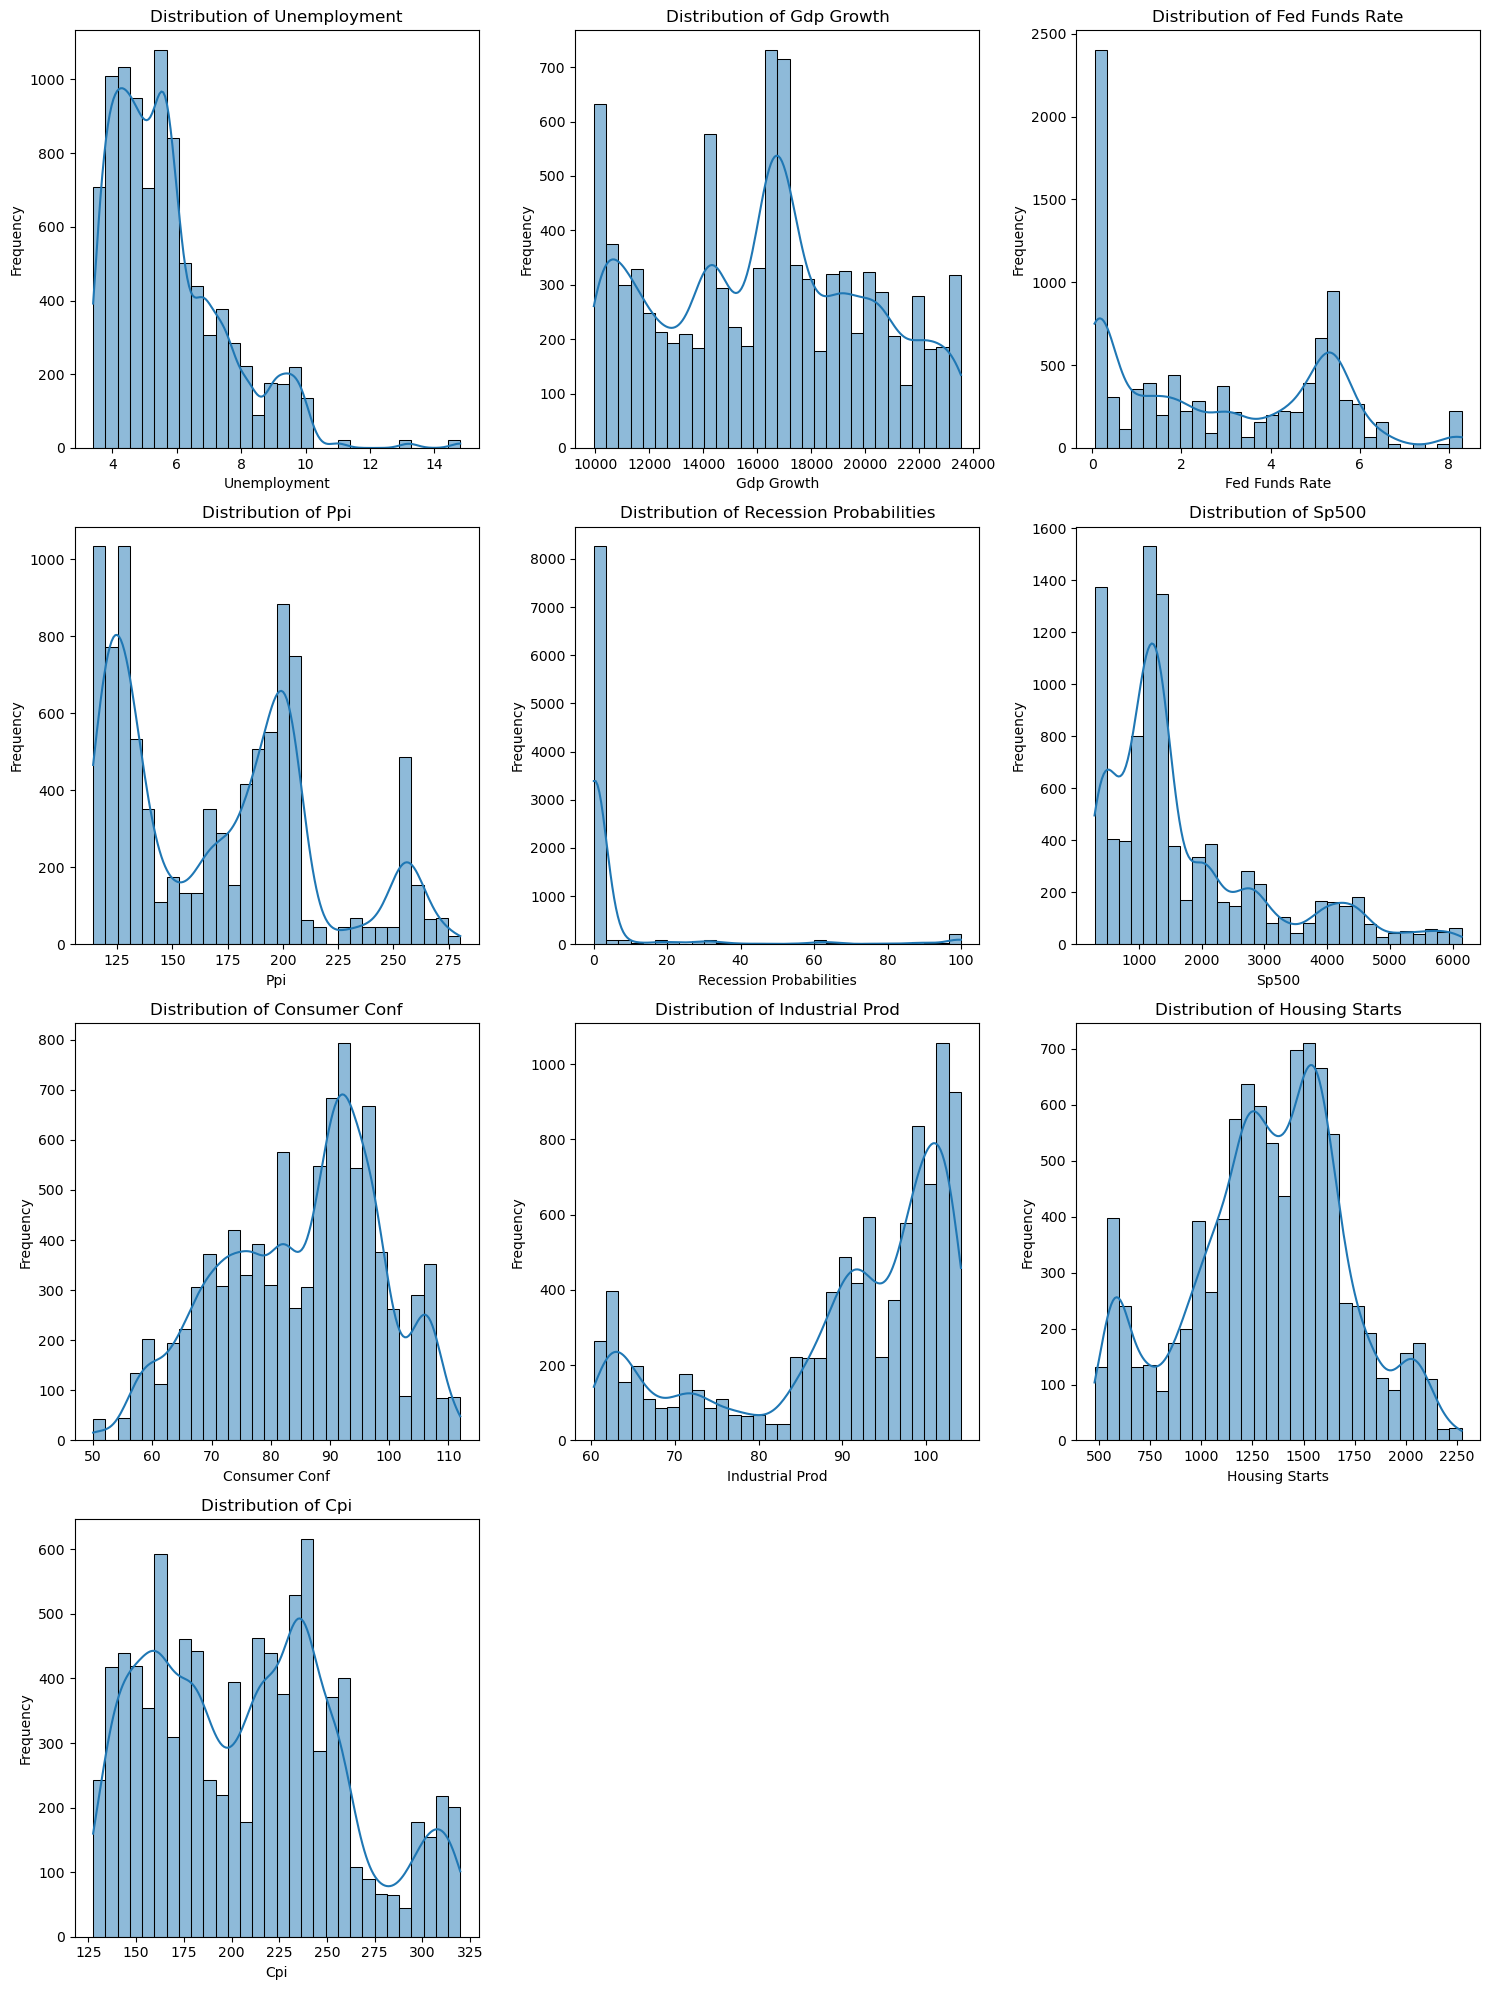

In [21]:
# Plot distribution of key indicators
key_indicators = [
    'unemployment', 
    'GDP_Growth', 
    'fed_funds_rate', 
    'PPI', 
    'recession_probabilities', 
    'SP500',             
    'consumer_conf',     
    'industrial_prod',   
    'housing_starts',    
    'CPI'                
]

# Adjust subplot layout dynamically based on number of indicators
num_indicators = len(key_indicators)
cols = 3  # Set to 3 columns for better layout
rows = int(np.ceil(num_indicators / cols))  # Calculate required rows

plt.figure(figsize=(15, 5 * rows))  # Dynamic height based on rows
for i, indicator in enumerate(key_indicators, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(economic_indicators[indicator].dropna(), bins=30, kde=True, color='tab:blue')
    plt.title(f'Distribution of {indicator.replace("_", " ").title()}')
    plt.xlabel(indicator.replace('_', ' ').title())
    plt.ylabel('Frequency')

plt.tight_layout()

# Save the plot to the images folder
plt.savefig('images/distribution_of_key_indicators.png', dpi=300, bbox_inches='tight')
plt.show();

## Distribution Insights of Key Economic Indicators

### **1. Unemployment**
- The distribution is **right-skewed**, meaning most of the time unemployment is between **4% and 6%**, which aligns with stable economic conditions.
- There are some **rare high spikes** (above 10%), representing major recessions like 2008 and COVID-19.

> **Takeaway:** Unemployment is normally low, but large jumps are strong signals of recession impact.

---

### **2. GDP Growth**
- The distribution shows **multiple peaks**, suggesting that GDP growth doesn’t follow a single, stable pattern — likely due to changes across business cycles, inflation adjustments, or long-term economic shifts.
- There's a **bimodal tendency** around ~12,000 and ~17,000, possibly due to structural shifts over decades.

> **Takeaway:** GDP growth is not stationary — it's steadily growing over time, so absolute values may need normalization or differencing for modeling.

---

### **3. Fed Funds Rate**
- Very **right-skewed** with a large spike at or near **0%**, reflecting extended periods of near-zero rates (e.g., post-2008 and COVID).
- Another cluster occurs around **5–6%**, reflecting pre-2000 monetary policy periods.

> **Takeaway:** Interest rate regimes shift significantly over time — recent years have been unusually low.

---
## Recession-Based Distribution Analysis

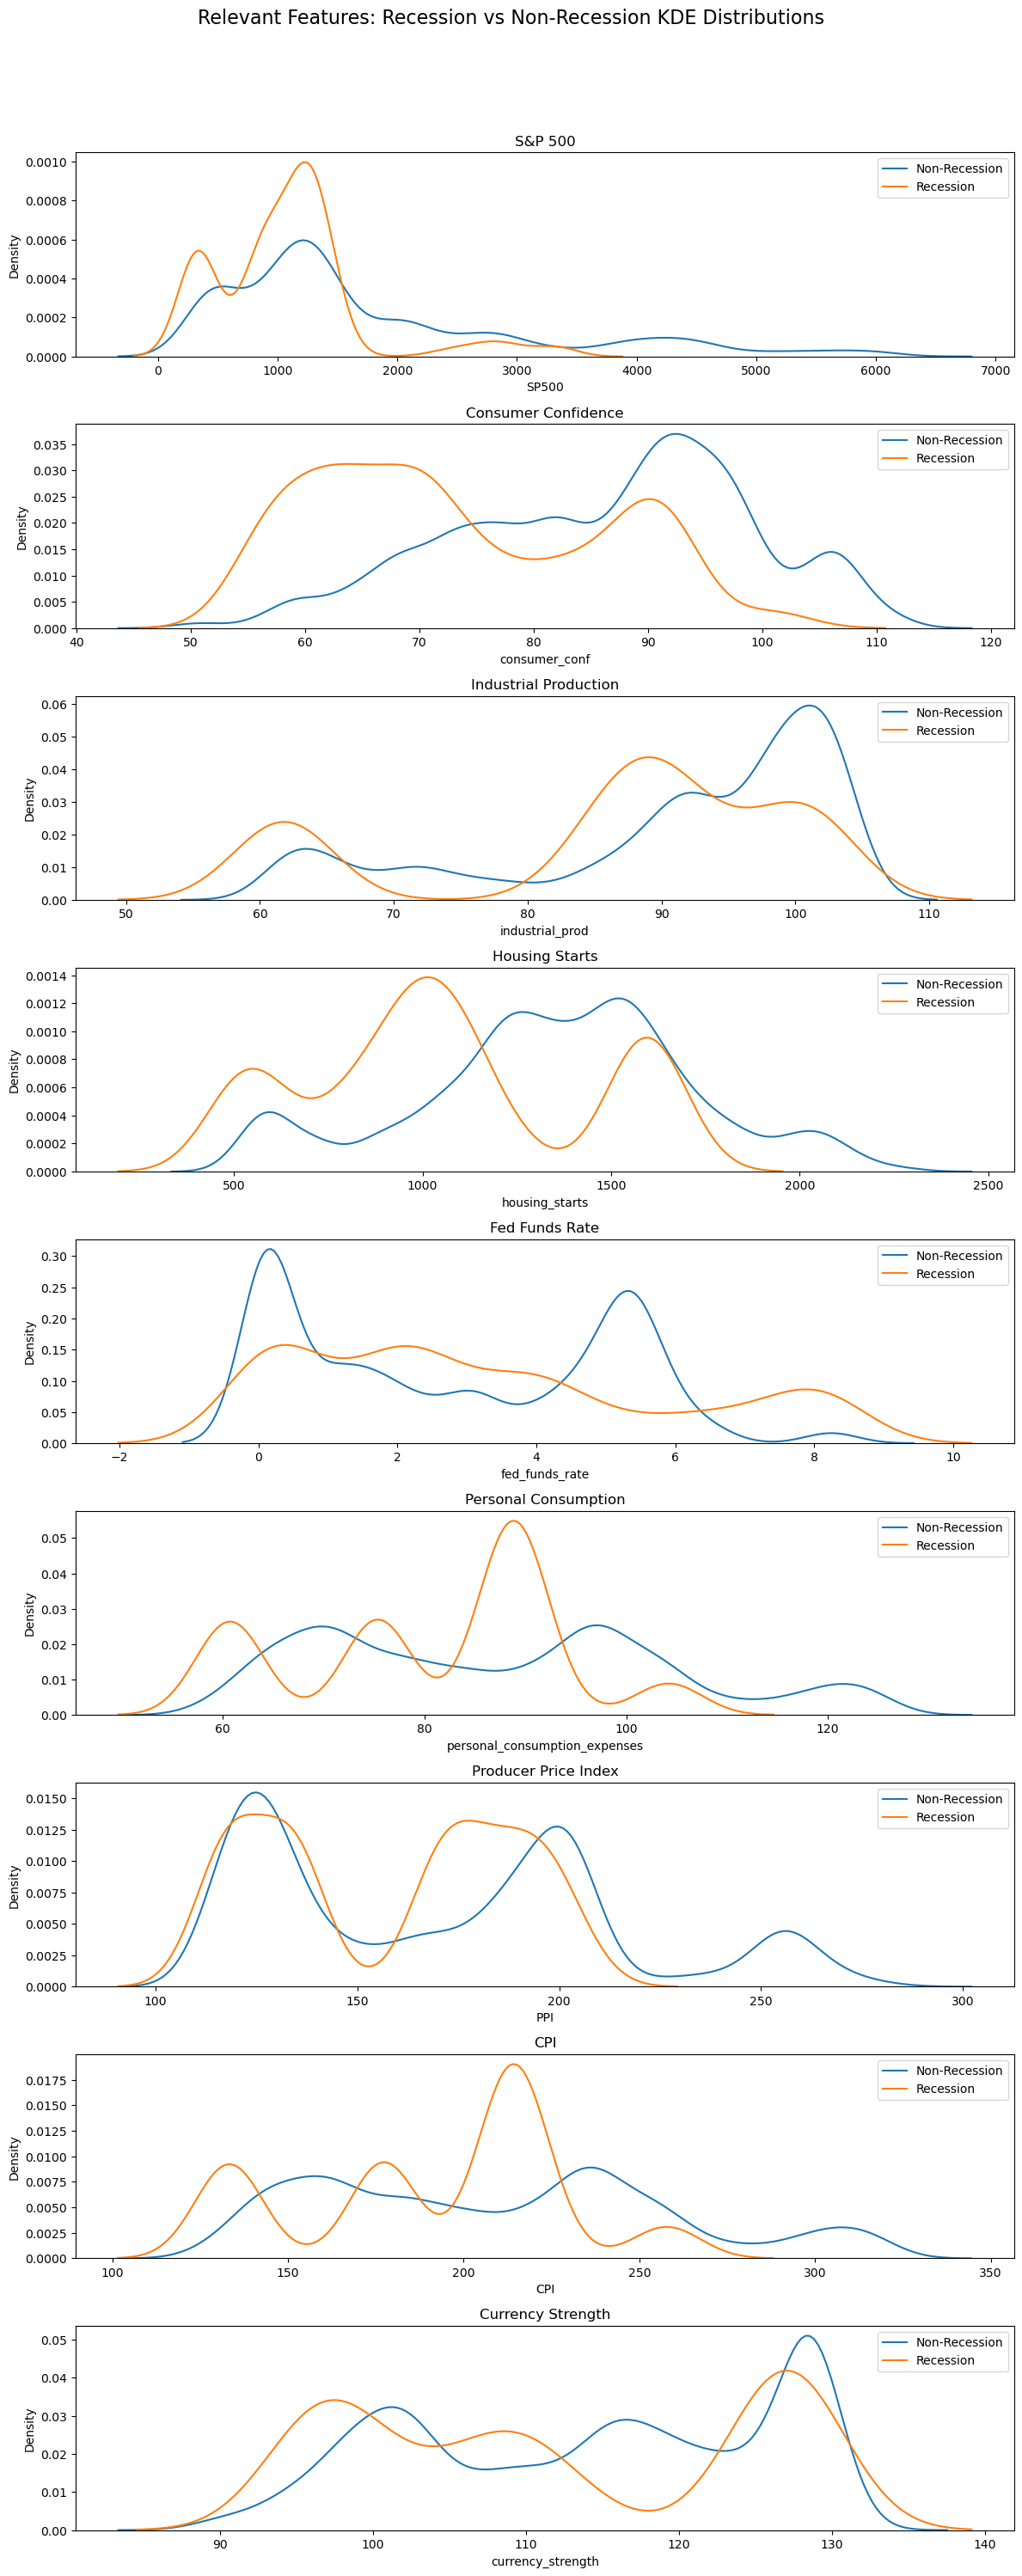

In [23]:
economic_indicators_with_labels = economic_indicators.copy()

# Define the recession periods
recession_periods = [
    ('1990-07-01', '1991-03-31'),
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Apply recession labels
economic_indicators_with_labels['Recession'] = 0
for start, end in recession_periods:
    economic_indicators_with_labels.loc[
        (economic_indicators_with_labels.index >= start) &
        (economic_indicators_with_labels.index <= end), 'Recession'
    ] = 1

# Split into recession vs non-recession groups
recession_df = economic_indicators_with_labels[economic_indicators_with_labels['Recession'] == 1]
non_recession_df = economic_indicators_with_labels[economic_indicators_with_labels['Recession'] == 0]

# Define features to plot
features_to_plot = [
    ('SP500', 'S&P 500'),
    ('consumer_conf', 'Consumer Confidence'),
    ('industrial_prod', 'Industrial Production'),
    ('housing_starts', 'Housing Starts'),
    ('fed_funds_rate', 'Fed Funds Rate'),
    ('personal_consumption_expenses', 'Personal Consumption'),
    ('PPI', 'Producer Price Index'),
    ('CPI', 'CPI'),
    ('currency_strength', 'Currency Strength')
]

# Create subplots
fig, axs = plt.subplots(len(features_to_plot), 1, figsize=(12, 3.5 * len(features_to_plot)))
fig.suptitle("Relevant Features: Recession vs Non-Recession KDE Distributions", fontsize=16)

# Plot each feature
for i, (feature, label) in enumerate(features_to_plot):
    sns.kdeplot(non_recession_df[feature], ax=axs[i], label='Non-Recession')
    sns.kdeplot(recession_df[feature], ax=axs[i], label='Recession')
    axs[i].set_title(label)
    axs[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot to the images folder
plt.savefig('images/recession_vs_non_recession_kde.png')
plt.show();

### What We're Communicating with These Plots

These KDE plots compare the **distribution of key economic indicators** during **recession vs non-recession periods**. Each curve helps us visually understand how each indicator behaves depending on the economic cycle.

---

###  What We Learn from Each Feature

### **1. S&P 500**
- Recession periods (orange) are centered at **much lower index values**.
- This confirms that **market downturns are strongly associated with recessions**.

> *Good leading indicator.*

---

### **2. Consumer Confidence**
- Confidence is **consistently lower during recessions**.
- Suggests reduced consumer spending and pessimism.

> *Strong behavioral signal.*

---

### **3. Industrial Production**
- Output shifts lower in recessions.
- Reflects contraction in manufacturing and broader economic activity.

> *Matches macroeconomic expectations.*

---

### **4. Housing Starts**
- Fewer homes are started during recessions.
- Sensitive to interest rates and economic uncertainty.

> *Useful early signal, especially for 2008.*

---

### **5. Fed Funds Rate**
- Lower during recessions, but not exclusive to them.
- Reflects the **Fed's reaction** rather than a predictor.

> *Still informative, but more of a policy response.*

---

### **6. Personal Consumption**
- Spending drops during recessions.
- Closely tracks with GDP.

> *Very relevant, but highly correlated with other features.*

---

### **7. CPI (Inflation)**
- Slightly lower during recessions, but not a sharp distinction.
- Price levels don’t always drop immediately during recessions.

> *Could require lagging or looking at rate of change.*

---

### **8. Currency Strength**
- Slight downward shift in recessions.
- Likely influenced by global risk sentiment or trade dynamics.

> *Not a strong standalone predictor, but still useful contextually.*

---


### **9. Producer Price Index (PPI) and Tariff Impacts**

- **PPI Trends During Recessions:**
  - Historically, the PPI curve for recessions skews **lower**, indicating that producer-level prices tend to **cool off during economic downturns**. This reflects reduced demand and diminished pricing power among producers.

- **Impact of Tariffs on PPI:**
  - **Trump Administration Tariffs (2018–2019):**
    - The imposition of tariffs on steel, aluminum, and a range of Chinese goods led to a noticeable **increase in PPI** during this period. Producers faced higher input costs due to these tariffs, which, in some cases, were passed on to consumers, contributing to inflationary pressures.
    - However, this surge in PPI was **not sustained**, as the onset of the COVID-19 pandemic in 2020 led to a global economic slowdown, reducing demand and subsequently causing PPI to dip.

  - **Biden Administration Tariffs (2024–2025):**
    - In an effort to protect American industries and address trade imbalances, the Biden administration announced significant **tariff increases on Chinese imports** in May 2024. These included:
      - **Electric Vehicles (EVs):** Tariffs increased from 25% to 100%.
      - **Solar Cells:** Tariffs doubled from 25% to 50%.
      - **Steel and Aluminum Products:** Tariffs raised to 25%.
    - These measures targeted approximately $18 billion worth of Chinese goods, aiming to bolster domestic production and counteract unfair trade practices.
    - The implementation of these tariffs is expected to exert **upward pressure on PPI**, as producers adjust to increased costs for imported materials and components.

- **Recent Developments (April 2025):**
  - President Donald Trump announced a new wave of sweeping tariffs on imports from multiple countries, with some tariffs reaching as high as 50%. 
  - These actions have intensified global trade tensions and are projected to have significant economic implications, including potential increases in producer prices.
  - Economists warn that these tariffs could lead to higher inflation and a slowdown in economic growth, further influencing PPI trends.

> *PPI is highly sensitive to global trade dynamics and policy-induced cost shocks. Monitoring PPI provides valuable insights into how external factors, such as tariffs, impact producer costs and pricing strategies, which are crucial for anticipating broader economic trends.*

## Data Preparation
This section prepares the data for machine learning by cleaning, scaling, and structuring it appropriately for recession prediction modeling.